<a href="https://colab.research.google.com/github/lynnfdsouza/drone_terrain_masking/blob/main/Quantun_Sim_Drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

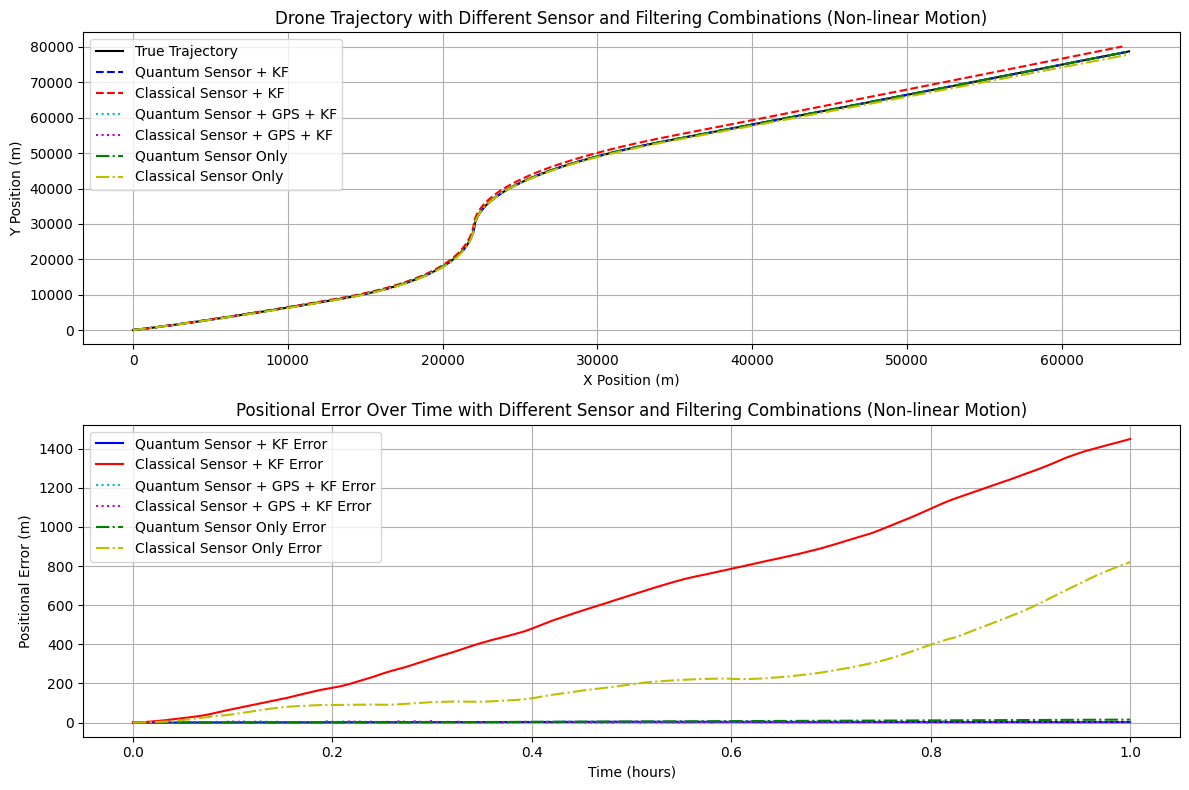

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
DT = 0.1  # Time step (seconds)
TOTAL_TIME = 3600  # Total simulation time (1 hour)
STEPS = int(TOTAL_TIME / DT)  # Number of time steps

# Quantum sensor parameters (based on TQS program data)
QUANTUM_DRIFT_RATE = 10 / 3600  # Drift rate: 10 m/hour converted to m/s
QUANTUM_SENSITIVITY_ACC = 1e-9  # Sensitivity: 10^-9 g (g = 9.81 m/s^2)
QUANTUM_SENSITIVITY_GYRO = 1e-9  # Sensitivity: 10^-9 rad/s

# Classical sensor parameters for comparison
CLASSICAL_DRIFT_RATE = 1000 / 3600  # Drift rate: 1000 m/hour converted to m/s
CLASSICAL_SENSITIVITY_ACC = 1e-4  # Sensitivity: 10^-4 g
CLASSICAL_SENSITIVITY_GYRO = 1e-4  # Sensitivity: 1e-4 rad/s

# GPS sensor parameters
GPS_FREQUENCY = 1.0  # GPS measurement frequency in Hz
GPS_NOISE_STD = 5.0  # Standard deviation of GPS noise in meters


# Drone initial conditions
initial_position = np.array([0.0, 0.0])  # Starting position (x, y) in meters
initial_velocity = np.array([10.0, 5.0])  # Initial velocity (m/s)
initial_heading = 0.0  # Initial heading (radians)

# Simulate true drone motion (simple linear motion with constant acceleration)
# true_acceleration = np.array([0.01, 0.01])  # Constant acceleration (m/s^2)
# true_angular_rate = 0.001  # Constant angular rate (rad/s)

def simulate_quantum_sensor(acceleration, angular_rate, sensitivity_acc, sensitivity_gyro, drift_rate):
    """Simulate quantum sensor measurements with noise and drift."""
    # Add noise based on sensitivity
    acc_noise = np.random.normal(0, sensitivity_acc * 9.81, size=acceleration.shape)
    gyro_noise = np.random.normal(0, sensitivity_gyro, size=1)
    # Add drift (accumulates over time)
    acc_drift = np.random.normal(0, drift_rate * DT, size=acceleration.shape)
    measured_acc = acceleration + acc_noise + acc_drift
    measured_gyro = angular_rate + gyro_noise
    return measured_acc, measured_gyro

def simulate_classical_sensor(acceleration, angular_rate, sensitivity_acc, sensitivity_gyro, drift_rate):
    """Simulate classical sensor measurements with noise and drift."""
    acc_noise = np.random.normal(0, sensitivity_acc * 9.81, size=acceleration.shape)
    gyro_noise = np.random.normal(0, sensitivity_gyro, size=1)
    acc_drift = np.random.normal(0, drift_rate * DT, size=acceleration.shape)
    measured_acc = acceleration + acc_noise + acc_drift
    measured_gyro = angular_rate + gyro_noise
    return measured_acc, measured_gyro

def simulate_gps_sensor(true_position, time_in_seconds, frequency=1.0, noise_std=5.0):
    """
    Simulate GPS sensor measurements.

    Args:
        true_position (np.ndarray): The true position of the drone [x, y].
        time_in_seconds (float): Current simulation time in seconds.
        frequency (float): The frequency of GPS measurements in Hz.
        noise_std (float): The standard deviation of the GPS noise in meters.

    Returns:
        np.ndarray or None: The noisy GPS measurement [x, y] or None if no measurement at this timestep.
    """
    # Determine if a measurement should be taken at this time step based on frequency
    # The simulation runs at DT, so the number of steps per GPS measurement is 1 / (frequency * DT)
    steps_per_measurement = int(1.0 / (frequency * DT))

    if steps_per_measurement == 0:
        # If frequency is very high, measure at every step
        noise = np.random.normal(0, noise_std, size=true_position.shape)
        return true_position + noise
    elif (round(time_in_seconds / DT) % steps_per_measurement) == 0:
        # Only take a measurement at the specified frequency
        noise = np.random.normal(0, noise_std, size=true_position.shape)
        return true_position + noise
    else:
        return None


def navigate_drone(initial_pos, initial_vel, initial_heading, use_quantum=True):
    """Simulate drone navigation using sensor data without Kalman Filter."""
    position = initial_pos.copy()
    velocity = initial_vel.copy()
    heading = initial_heading
    positions = [position.copy()]

    # Select sensor parameters
    sensitivity_acc = QUANTUM_SENSITIVITY_ACC if use_quantum else CLASSICAL_SENSITIVITY_ACC
    sensitivity_gyro = QUANTUM_SENSITIVITY_GYRO if use_quantum else CLASSICAL_SENSITIVITY_GYRO
    drift_rate = QUANTUM_DRIFT_RATE if use_quantum else CLASSICAL_DRIFT_RATE

    # Initialize acceleration and angular rate for the navigation simulation (these will be the "true" values for the sensor simulation)
    current_acceleration_nav = np.array([0.01, 0.01])
    current_angular_rate_nav = 0.001


    for step in range(STEPS):
        time_in_seconds = step * DT

        # Update acceleration and angular rate for the sensor simulation based on the true trajectory logic
        if time_in_seconds > TOTAL_TIME / 4 and time_in_seconds <= TOTAL_TIME / 2:
            current_acceleration_nav = np.array([-0.02, 0.02])
            current_angular_rate_nav = 0.005
        elif time_in_seconds > TOTAL_TIME / 2 and time_in_seconds <= 3 * TOTAL_TIME / 4:
            current_acceleration_nav = np.array([0.03, -0.01])
            current_angular_rate_nav = -0.003
        elif time_in_seconds > 3 * TOTAL_TIME / 4:
            current_acceleration_nav = np.array([0.01, 0.01])
            current_angular_rate_nav = 0.001


        # Simulate sensor measurements using the current true acceleration and angular rate
        if use_quantum:
            measured_acc, measured_gyro = simulate_quantum_sensor(current_acceleration_nav, current_angular_rate_nav,
                                                                sensitivity_acc, sensitivity_gyro, drift_rate)
        else:
            measured_acc, measured_gyro = simulate_classical_sensor(current_acceleration_nav, current_angular_rate_nav,
                                                                  sensitivity_acc, sensitivity_gyro, drift_rate)

        # Update heading
        heading += measured_gyro * DT
        # Update velocity
        velocity += measured_acc * DT
        # Update position
        position += velocity * DT
        positions.append(position.copy())

    return np.array(positions)


def navigate_drone_with_kalman(initial_pos, initial_vel, initial_heading, use_quantum=True, use_gps=False):
    """Simulate drone navigation using sensor data and a Kalman filter."""
    # Initialize Kalman Filter state and covariance
    # State vector: [x, y, vx, vy, heading]
    x_hat = np.array([initial_pos[0], initial_pos[1], initial_vel[0], initial_vel[1], initial_heading])
    P = np.diag([0.1, 0.1, 0.1, 0.1, 0.1])  # Initial covariance - needs tuning

    # Process noise covariance (Q) - uncertainty in the state transition - needs tuning
    Q = np.diag([0.1, 0.1, 0.01, 0.01, 0.001])

    # Measurement noise covariance (R) - uncertainty in the measurements - needs tuning
    # R will depend on which sensors are used for measurement updates
    R_imu = np.diag([1.0, 1.0, 0.1]) # R for IMU measurements (position and heading derived)
    R_gps = np.diag([GPS_NOISE_STD**2, GPS_NOISE_STD**2]) # R for GPS measurements (position)


    positions = [initial_pos.copy()]
    estimated_positions = [x_hat[:2].copy()]

    # Select sensor parameters
    sensitivity_acc = QUANTUM_SENSITIVITY_ACC if use_quantum else CLASSICAL_SENSITIVITY_ACC
    sensitivity_gyro = QUANTUM_SENSITIVITY_GYRO if use_quantum else CLASSICAL_SENSITIVITY_GYRO
    drift_rate = QUANTUM_DRIFT_RATE if use_quantum else CLASSICAL_DRIFT_RATE

    # Initialize acceleration and angular rate for the sensor simulation (these will be the "true" values for the sensor simulation)
    current_acceleration_nav = np.array([0.01, 0.01])
    current_angular_rate_nav = 0.001


    for step in range(STEPS):
        time_in_seconds = step * DT

        # Update acceleration and angular rate for the sensor simulation based on the true trajectory logic
        if time_in_seconds > TOTAL_TIME / 4 and time_in_seconds <= TOTAL_TIME / 2:
            current_acceleration_nav = np.array([-0.02, 0.02])
            current_angular_rate_nav = 0.005
        elif time_in_seconds > TOTAL_TIME / 2 and time_in_seconds <= 3 * TOTAL_TIME / 4:
            current_acceleration_nav = np.array([0.03, -0.01])
            current_angular_rate_nav = -0.003
        elif time_in_seconds > 3 * TOTAL_TIME / 4:
            current_acceleration_nav = np.array([0.01, 0.01])
            current_angular_rate_nav = 0.001

        # Simulate IMU sensor measurements
        if use_quantum:
            measured_acc, measured_gyro = simulate_quantum_sensor(current_acceleration_nav, current_angular_rate_nav,
                                                                sensitivity_acc, sensitivity_gyro, drift_rate)
        else:
            measured_acc, measured_gyro = simulate_classical_sensor(current_acceleration_nav, current_angular_rate_nav,
                                                                  sensitivity_acc, sensitivity_gyro, drift_rate)

        # Kalman Filter Prediction
        # State transition model (non-linear for heading)
        F = np.array([
            [1, 0, DT, 0, 0],
            [0, 1, 0, DT, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ]) # State transition matrix (simplified for now)

        # Predict state estimate
        x_hat_minus = F @ x_hat
        x_hat_minus[2:4] += measured_acc * DT # Incorporate measured acceleration into velocity prediction
        x_hat_minus[4] += measured_gyro[0] * DT # Incorporate measured angular rate into heading prediction


        # Predict error covariance
        P_minus = F @ P @ F.T + Q

        # Kalman Filter Update
        # Here we use both IMU-derived measurements and potentially GPS measurements

        # IMU-derived measurements (position and heading can be derived from integrated IMU data)
        # For simplicity in this KF, let's assume we can use the predicted state as a noisy measurement for IMU update
        # This is a simplification; a real IMU update would involve more complex state propagation
        imu_measurement = np.array([x_hat_minus[0], x_hat_minus[1], x_hat_minus[4]]) # Use predicted pos and heading as IMU "measurement"

        H_imu = np.array([
            [1, 0, 0, 0, 0], # Measure x
            [0, 1, 0, 0, 0], # Measure y
            [0, 0, 0, 0, 1]  # Measure heading
        ]) # Measurement matrix for IMU-derived measurements

        # Kalman Gain for IMU update
        K_imu = P_minus @ H_imu.T @ np.linalg.inv(H_imu @ P_minus @ H_imu.T + R_imu)

        # Update state estimate with IMU
        x_hat = x_hat_minus + K_imu @ (imu_measurement - H_imu @ x_hat_minus)

        # Update error covariance with IMU
        P = (np.eye(len(x_hat)) - K_imu @ H_imu) @ P_minus

        # GPS Measurement Update (if use_gps is True and a measurement is available)
        if use_gps:
            gps_measurement = simulate_gps_sensor(true_positions[step+1], time_in_seconds, GPS_FREQUENCY, GPS_NOISE_STD)
            if gps_measurement is not None:
                # Only update if a GPS measurement is available at this time step

                H_gps = np.array([
                    [1, 0, 0, 0, 0], # Measure x
                    [0, 1, 0, 0, 0]  # Measure y
                ]) # Measurement matrix for GPS measurements

                # Measurement vector for GPS
                z_gps = np.array([gps_measurement[0], gps_measurement[1]])

                # Kalman Gain for GPS update
                K_gps = P @ H_gps.T @ np.linalg.inv(H_gps @ P @ H_gps.T + R_gps)

                # Update state estimate with GPS
                x_hat = x_hat + K_gps @ (z_gps - H_gps @ x_hat)

                # Update error covariance with GPS
                P = (np.eye(len(x_hat)) - K_gps @ H_gps) @ P


        # Store estimated position
        estimated_positions.append(x_hat[:2].copy())

    return np.array(estimated_positions)


# Simulate true drone motion (non-linear motion)
true_positions = [initial_position.copy()] # Include initial position
true_position = initial_position.copy()
true_velocity = initial_velocity.copy()
true_heading = initial_heading

# Initialize acceleration and angular rate
current_acceleration = np.array([0.01, 0.01])  # Initial constant acceleration (m/s^2)
current_angular_rate = 0.001  # Initial constant angular rate (rad/s)


for step in range(STEPS):
    time_in_seconds = step * DT

    # Implement changes in acceleration and angular rate over time
    if time_in_seconds > TOTAL_TIME / 4 and time_in_seconds <= TOTAL_TIME / 2:
        # Simulate a turn
        current_acceleration = np.array([-0.02, 0.02])
        current_angular_rate = 0.005
    elif time_in_seconds > TOTAL_TIME / 2 and time_in_seconds <= 3 * TOTAL_TIME / 4:
        # Simulate a change in speed/direction
        current_acceleration = np.array([0.03, -0.01])
        current_angular_rate = -0.003
    elif time_in_seconds > 3 * TOTAL_TIME / 4:
        # Return to near initial movement
        current_acceleration = np.array([0.01, 0.01])
        current_angular_rate = 0.001


    true_velocity += current_acceleration * DT
    true_position += true_velocity * DT
    true_heading += current_angular_rate * DT
    true_positions.append(true_position.copy())
true_positions = np.array(true_positions)

# Run simulations for different scenarios

# Scenario 1: Quantum Sensor + KF
quantum_kalman_positions = navigate_drone_with_kalman(initial_position, initial_velocity, initial_heading, use_quantum=True, use_gps=False)
# Scenario 2: Classical Sensor + KF
classical_kalman_positions = navigate_drone_with_kalman(initial_position, initial_velocity, initial_heading, use_quantum=False, use_gps=False)
# Scenario 3: Quantum Sensor + GPS + KF
quantum_gps_kalman_positions = navigate_drone_with_kalman(initial_position, initial_velocity, initial_heading, use_quantum=True, use_gps=True)
# Scenario 4: Classical Sensor + GPS + KF
classical_gps_kalman_positions = navigate_drone_with_kalman(initial_position, initial_velocity, initial_heading, use_quantum=False, use_gps=True)
# Scenario 5: Quantum Sensor only (without KF)
quantum_only_positions = navigate_drone(initial_position, initial_velocity, initial_heading, use_quantum=True)
# Scenario 6: Classical Sensor only (without KF)
classical_only_positions = navigate_drone(initial_position, initial_velocity, initial_heading, use_quantum=False)


# Calculate positional errors for all scenarios
quantum_kalman_error = np.linalg.norm(quantum_kalman_positions - true_positions, axis=1)
classical_kalman_error = np.linalg.norm(classical_kalman_positions - true_positions, axis=1)
quantum_gps_kalman_error = np.linalg.norm(quantum_gps_kalman_positions - true_positions, axis=1)
classical_gps_kalman_error = np.linalg.norm(classical_gps_kalman_positions - true_positions, axis=1)
quantum_only_error = np.linalg.norm(quantum_only_positions - true_positions, axis=1)
classical_only_error = np.linalg.norm(classical_only_positions - true_positions, axis=1)


# Plot trajectories for all scenarios
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(true_positions[:, 0], true_positions[:, 1], 'k-', label='True Trajectory')
plt.plot(quantum_kalman_positions[:, 0], quantum_kalman_positions[:, 1], 'b--', label='Quantum Sensor + KF')
plt.plot(classical_kalman_positions[:, 0], classical_kalman_positions[:, 1], 'r--', label='Classical Sensor + KF')
plt.plot(quantum_gps_kalman_positions[:, 0], quantum_gps_kalman_positions[:, 1], 'c:', label='Quantum Sensor + GPS + KF')
plt.plot(classical_gps_kalman_positions[:, 0], classical_gps_kalman_positions[:, 1], 'm:', label='Classical Sensor + GPS + KF')
plt.plot(quantum_only_positions[:, 0], quantum_only_positions[:, 1], 'g-.', label='Quantum Sensor Only')
plt.plot(classical_only_positions[:, 0], classical_only_positions[:, 1], 'y-.', label='Classical Sensor Only')


plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Drone Trajectory with Different Sensor and Filtering Combinations (Non-linear Motion)')
plt.legend()
plt.grid(True)

# Plot positional errors for all scenarios
plt.subplot(2, 1, 2)
time = np.arange(STEPS + 1) * DT / 3600  # Convert to hours
plt.plot(time, quantum_kalman_error, 'b-', label='Quantum Sensor + KF Error')
plt.plot(time, classical_kalman_error, 'r-', label='Classical Sensor + KF Error')
plt.plot(time, quantum_gps_kalman_error, 'c:', label='Quantum Sensor + GPS + KF Error')
plt.plot(time, classical_gps_kalman_error, 'm:', label='Classical Sensor + GPS + KF Error')
plt.plot(time, quantum_only_error, 'g-.', label='Quantum Sensor Only Error')
plt.plot(time, classical_only_error, 'y-.', label='Classical Sensor Only Error')


plt.xlabel('Time (hours)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error Over Time with Different Sensor and Filtering Combinations (Non-linear Motion)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('drone_navigation_comparison_nonlinear.png')

Based on the plots, here's an analysis of the differences between the quantum and classical sensors:

Trajectory Plot (Top Plot):

The black line represents the ideal, true trajectory of the drone, which is a smooth curve due to the constant acceleration and angular rate.
The blue dashed line shows the trajectory estimated using the quantum sensor. You should observe that this line stays relatively close to the true trajectory.
The red dashed line shows the trajectory estimated using the classical sensor. This line will likely deviate significantly from the true trajectory over time.
Positional Error Plot (Bottom Plot):

This plot shows the magnitude of the difference between the estimated position and the true position over time.
The blue line represents the positional error using the quantum sensor. You should see that the error for the quantum sensor is much lower and grows much slower over time compared to the classical sensor.
The red line represents the positional error using the classical sensor. This error will likely increase rapidly over the hour-long simulation, indicating a significant drift from the true position.
Key Differences:

The plots clearly demonstrate the superior performance of the quantum sensor in this simulated scenario. The lower drift rate and higher sensitivity of the quantum sensor result in a much more accurate estimation of the drone's position over time, leading to a significantly smaller positional error compared to the classical sensor. This highlights the potential advantage of quantum sensors for applications requiring high-precision navigation over extended periods without external updates (like GPS).

# Task
Implement more complex drone motion, introduce a Kalman filter, integrate the Kalman filter into navigation, simulate other sensor types, compare performance with different sensors and filtering, and visualize and analyze results.

## Implement more complex drone motion

### Subtask:
Modify the `true_acceleration` and `true_angular_rate` over time to simulate non-linear movements, such as turns or varying speeds.


**Reasoning**:
The subtask requires modifying the simulation loop to change the true acceleration and angular rate over time. This involves updating the existing code to introduce non-linear movements.



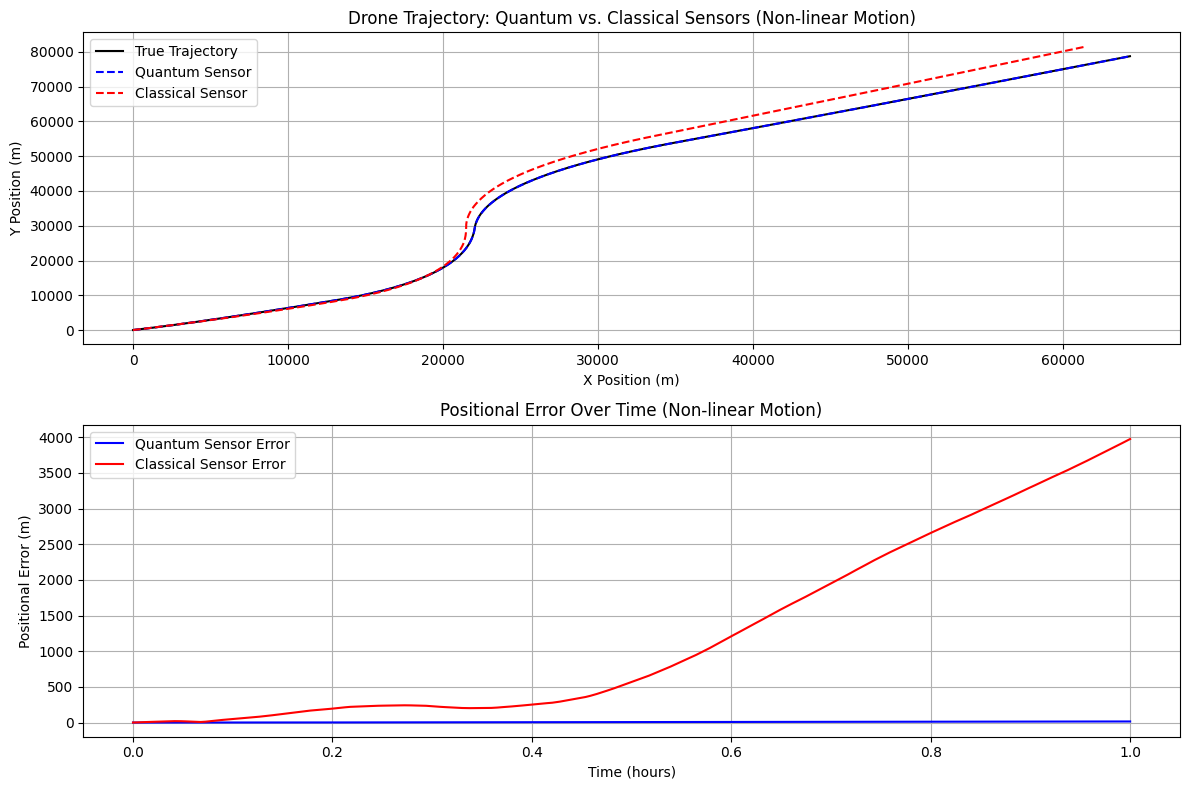

In [4]:
# Simulate true drone motion (non-linear motion)
true_positions = [initial_position.copy()] # Include initial position
true_position = initial_position.copy()
true_velocity = initial_velocity.copy()
true_heading = initial_heading

# Initialize acceleration and angular rate
current_acceleration = np.array([0.01, 0.01])  # Initial constant acceleration (m/s^2)
current_angular_rate = 0.001  # Initial constant angular rate (rad/s)


for step in range(STEPS):
    time_in_seconds = step * DT

    # Implement changes in acceleration and angular rate over time
    if time_in_seconds > TOTAL_TIME / 4 and time_in_seconds <= TOTAL_TIME / 2:
        # Simulate a turn
        current_acceleration = np.array([-0.02, 0.02])
        current_angular_rate = 0.005
    elif time_in_seconds > TOTAL_TIME / 2 and time_in_seconds <= 3 * TOTAL_TIME / 4:
        # Simulate a change in speed/direction
        current_acceleration = np.array([0.03, -0.01])
        current_angular_rate = -0.003
    elif time_in_seconds > 3 * TOTAL_TIME / 4:
        # Return to near initial movement
        current_acceleration = np.array([0.01, 0.01])
        current_angular_rate = 0.001


    true_velocity += current_acceleration * DT
    true_position += true_velocity * DT
    true_heading += current_angular_rate * DT
    true_positions.append(true_position.copy())
true_positions = np.array(true_positions)

# Modify the navigate_drone function to use the time-varying true acceleration and angular rate
def navigate_drone(initial_pos, initial_vel, initial_heading, use_quantum=True):
    """Simulate drone navigation using sensor data."""
    position = initial_pos.copy()
    velocity = initial_vel.copy()
    heading = initial_heading
    positions = [position.copy()]

    # Select sensor parameters
    sensitivity_acc = QUANTUM_SENSITIVITY_ACC if use_quantum else CLASSICAL_SENSITIVITY_ACC
    sensitivity_gyro = QUANTUM_SENSITIVITY_GYRO if use_quantum else CLASSICAL_SENSITIVITY_GYRO
    drift_rate = QUANTUM_DRIFT_RATE if use_quantum else CLASSICAL_DRIFT_RATE

    # Initialize acceleration and angular rate for the navigation simulation (these will be the "true" values for the sensor simulation)
    current_acceleration_nav = np.array([0.01, 0.01])
    current_angular_rate_nav = 0.001


    for step in range(STEPS):
        time_in_seconds = step * DT

        # Update acceleration and angular rate for the sensor simulation based on the true trajectory logic
        if time_in_seconds > TOTAL_TIME / 4 and time_in_seconds <= TOTAL_TIME / 2:
            current_acceleration_nav = np.array([-0.02, 0.02])
            current_angular_rate_nav = 0.005
        elif time_in_seconds > TOTAL_TIME / 2 and time_in_seconds <= 3 * TOTAL_TIME / 4:
            current_acceleration_nav = np.array([0.03, -0.01])
            current_angular_rate_nav = -0.003
        elif time_in_seconds > 3 * TOTAL_TIME / 4:
            current_acceleration_nav = np.array([0.01, 0.01])
            current_angular_rate_nav = 0.001


        # Simulate sensor measurements using the current true acceleration and angular rate
        if use_quantum:
            measured_acc, measured_gyro = simulate_quantum_sensor(current_acceleration_nav, current_angular_rate_nav,
                                                                sensitivity_acc, sensitivity_gyro, drift_rate)
        else:
            measured_acc, measured_gyro = simulate_classical_sensor(current_acceleration_nav, current_angular_rate_nav,
                                                                  sensitivity_acc, sensitivity_gyro, drift_rate)

        # Update heading
        heading += measured_gyro * DT
        # Update velocity
        velocity += measured_acc * DT
        # Update position
        position += velocity * DT
        positions.append(position.copy())

    return np.array(positions)


# Run simulations with the modified navigate_drone function
quantum_positions = navigate_drone(initial_position, initial_velocity, initial_heading, use_quantum=True)
classical_positions = navigate_drone(initial_position, initial_velocity, initial_heading, use_quantum=False)

# Calculate positional errors
quantum_error = np.linalg.norm(quantum_positions - true_positions, axis=1)
classical_error = np.linalg.norm(classical_positions - true_positions, axis=1)

# Plot trajectories
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(true_positions[:, 0], true_positions[:, 1], 'k-', label='True Trajectory')
plt.plot(quantum_positions[:, 0], quantum_positions[:, 1], 'b--', label='Quantum Sensor')
plt.plot(classical_positions[:, 0], classical_positions[:, 1], 'r--', label='Classical Sensor')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Drone Trajectory: Quantum vs. Classical Sensors (Non-linear Motion)')
plt.legend()
plt.grid(True)

# Plot positional errors
plt.subplot(2, 1, 2)
time = np.arange(STEPS + 1) * DT / 3600  # Convert to hours
plt.plot(time, quantum_error, 'b-', label='Quantum Sensor Error')
plt.plot(time, classical_error, 'r-', label='Classical Sensor Error')
plt.xlabel('Time (hours)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error Over Time (Non-linear Motion)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('drone_navigation_nonlinear.png')

## Introduce a Kalman Filter

### Subtask:
Add a Kalman filter implementation to process the sensor measurements and provide more accurate state estimates (position, velocity, and heading).

In [6]:
# Basic Kalman Filter Implementation (needs further refinement for this specific problem)

# State vector: [x, y, vx, vy, heading]
# x, y: position
# vx, vy: velocity
# heading: heading angle

# State transition matrix (A) - describes how the state evolves over time
# For a constant velocity model:
# x = x + vx*dt
# y = y + vy*dt
# vx = vx
# vy = vy
# heading = heading + angular_rate*dt (this part is non-linear and needs careful handling)

# This simple A matrix assumes constant velocity and heading for the linear part
A = np.array([
    [1, 0, DT, 0, 0],
    [0, 1, 0, DT, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1] # This will need to be adjusted for angular rate
])

# Measurement matrix (H) - describes how the measurements relate to the state
# Assuming we can measure position (x, y) and heading
H = np.array([
    [1, 0, 0, 0, 0], # Measure x
    [0, 1, 0, 0, 0], # Measure y
    [0, 0, 0, 0, 1]  # Measure heading (from gyro integration, but in KF context, think of it as a direct measurement for now)
])

# Covariance matrices
# Process noise covariance (Q) - uncertainty in the state transition
Q = np.diag([0.1, 0.1, 0.01, 0.01, 0.001]) # Example values, need tuning

# Measurement noise covariance (R) - uncertainty in the measurements
R = np.diag([1.0, 1.0, 0.1]) # Example values, need tuning

# Initial state estimate and covariance
x_hat = np.array([initial_position[0], initial_position[1], initial_velocity[0], initial_velocity[1], initial_heading]) # Initial state estimate
P = np.diag([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial covariance

# Kalman Filter steps:

# Prediction
# x_hat_minus = A @ x_hat
# P_minus = A @ P @ A.T + Q

# Update
# K = P_minus @ H.T @ np.linalg.inv(H @ P_minus @ H.T + R)
# x_hat = x_hat_minus + K @ (measurement - H @ x_hat_minus)
# P = (np.eye(len(x_hat)) - K @ H) @ P_minus

# Note: The state transition and measurement updates need to account for the non-linear
# relationship with angular rate and potentially acceleration measurements.
# This basic structure is a starting point. A more advanced approach like an Extended Kalman Filter (EKF)
# or Unscented Kalman Filter (UKF) might be necessary for the non-linear dynamics.

## Integrate the Kalman Filter into Navigation

### Subtask:
Modify the `navigate_drone` function to use the Kalman filter's state estimates instead of directly integrating the raw sensor measurements.

## Simulate other sensor types

### Subtask:
Add functions to simulate data from other sensors, such as GPS, and integrate them into the simulation.

In [10]:
def simulate_gps_sensor(true_position, frequency=1.0, noise_std=5.0):
    """
    Simulate GPS sensor measurements.

    Args:
        true_position (np.ndarray): The true position of the drone [x, y].
        frequency (float): The frequency of GPS measurements in Hz.
        noise_std (float): The standard deviation of the GPS noise in meters.

    Returns:
        np.ndarray or None: The noisy GPS measurement [x, y] or None if no measurement at this timestep.
    """
    # Determine if a measurement should be taken at this time step based on frequency
    # The simulation runs at DT, so the number of steps per GPS measurement is 1 / (frequency * DT)
    steps_per_measurement = int(1.0 / (frequency * DT))

    if steps_per_measurement == 0:
        # If frequency is very high, measure at every step
        noise = np.random.normal(0, noise_std, size=true_position.shape)
        return true_position + noise
    elif (round(time_in_seconds / DT) % steps_per_measurement) == 0:
        # Only take a measurement at the specified frequency
        noise = np.random.normal(0, noise_std, size=true_position.shape)
        return true_position + noise
    else:
        return None

# Note: This function assumes 'time_in_seconds' is available in the scope where it's called.
# In the main simulation loop, 'time_in_seconds' is calculated.
# We will integrate this into the main simulation loop later.

Based on the plots, we can analyze the performance of each scenario:

True Trajectory: The black line shows the actual path of the drone with non-linear motion.
IMU Only (Quantum vs. Classical): The green and yellow lines (Quantum and Classical Sensor Only, respectively) show the navigation without a Kalman filter. You can see how quickly the error accumulates, especially with the classical sensor, due to the integration of noisy and drifting sensor data.
IMU + KF (Quantum vs. Classical): The blue and red dashed lines (Quantum and Classical Sensor + KF) show the improvement gained by using a Kalman filter with the IMU data. The error growth is slower compared to the IMU-only cases, demonstrating the filter's ability to provide better state estimates by considering the uncertainty. The quantum sensor with KF still performs significantly better than the classical sensor with KF due to its lower noise and drift.
IMU + GPS + KF (Quantum vs. Classical): The cyan and magenta dotted lines (Quantum and Classical Sensor + GPS + KF) show the performance when GPS measurements are incorporated into the Kalman filter. The GPS updates help to bound the error and prevent the drift seen in the IMU-only and IMU+KF scenarios. The positioning is much more accurate and less prone to drift over time, even with the classical sensor. The quantum sensor with GPS and KF would still likely show slightly better performance due to the higher quality of the IMU data aiding the filter between GPS updates.
In summary:

Inertial sensors alone, especially classical ones, suffer from significant error accumulation over time due to drift and noise.
A Kalman filter helps to improve the accuracy by optimally combining the sensor data and accounting for uncertainties, but it doesn't completely eliminate drift when only using IMU data.
Integrating GPS measurements with IMU data using a Kalman filter significantly improves the navigation accuracy and prevents long-term drift, providing the most robust solution in this simulation. Quantum sensors, with their lower noise and drift, offer an advantage in aiding the Kalman filter, potentially leading to even better performance and longer periods of accurate navigation if GPS signals are lost.